In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

In [83]:
np.set_printoptions(linewidth=150)

In [4]:
df = pd.read_csv("EThOSCSV_201803.csv")

In [5]:
# TODO Can I prevent global namespace pollution by having everything inside let-clauses?

In [6]:
def isphd(elem):
    """ Return true if elem["Qualification"] is a PhD. """
    q = elem["Qualification"]
    if type(q) == str:
        qred = q.strip().lower()
        if ("ph.d" in qred or "dphil" in qred or "phd" in qred):
            return True
    return False

In [7]:
dfphd = df[df.apply(isphd, axis=1)]

In [8]:
counts_by_year = dfphd.Date.value_counts().sort_index()

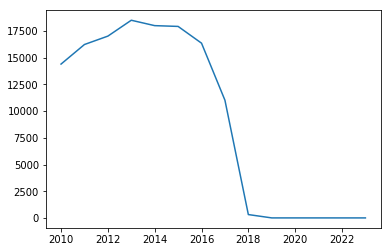

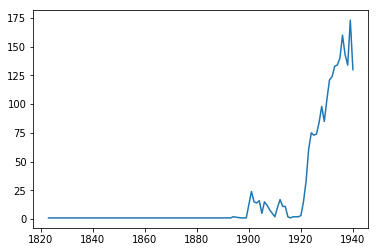

In [9]:
plt.figure()
counts_by_year[2010:].plot()
plt.figure()
counts_by_year[:1940].plot()

In [10]:
late_cutoff = 2015
early_cutoff = 1925
counts_by_year = counts_by_year[early_cutoff:late_cutoff]
dfphd = dfphd[(early_cutoff <= dfphd.Date) & (dfphd.Date <= late_cutoff)]

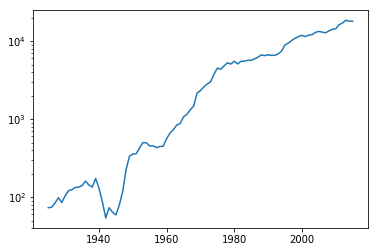

In [11]:
plt.figure()
plt.semilogy(counts_by_year)

In [12]:
counts_by_yearandinst = dfphd.groupby(["Institution", "Date"]).size().unstack("Institution").fillna(0.0)
counts_by_yearandinst = counts_by_yearandinst.sort_values(late_cutoff, axis="columns", ascending=False)
instratios_by_year = counts_by_yearandinst.divide(counts_by_year, axis="index")

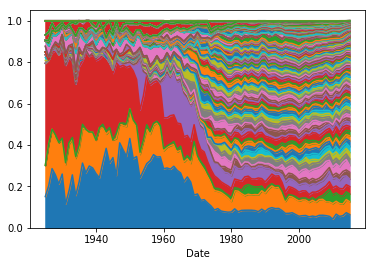

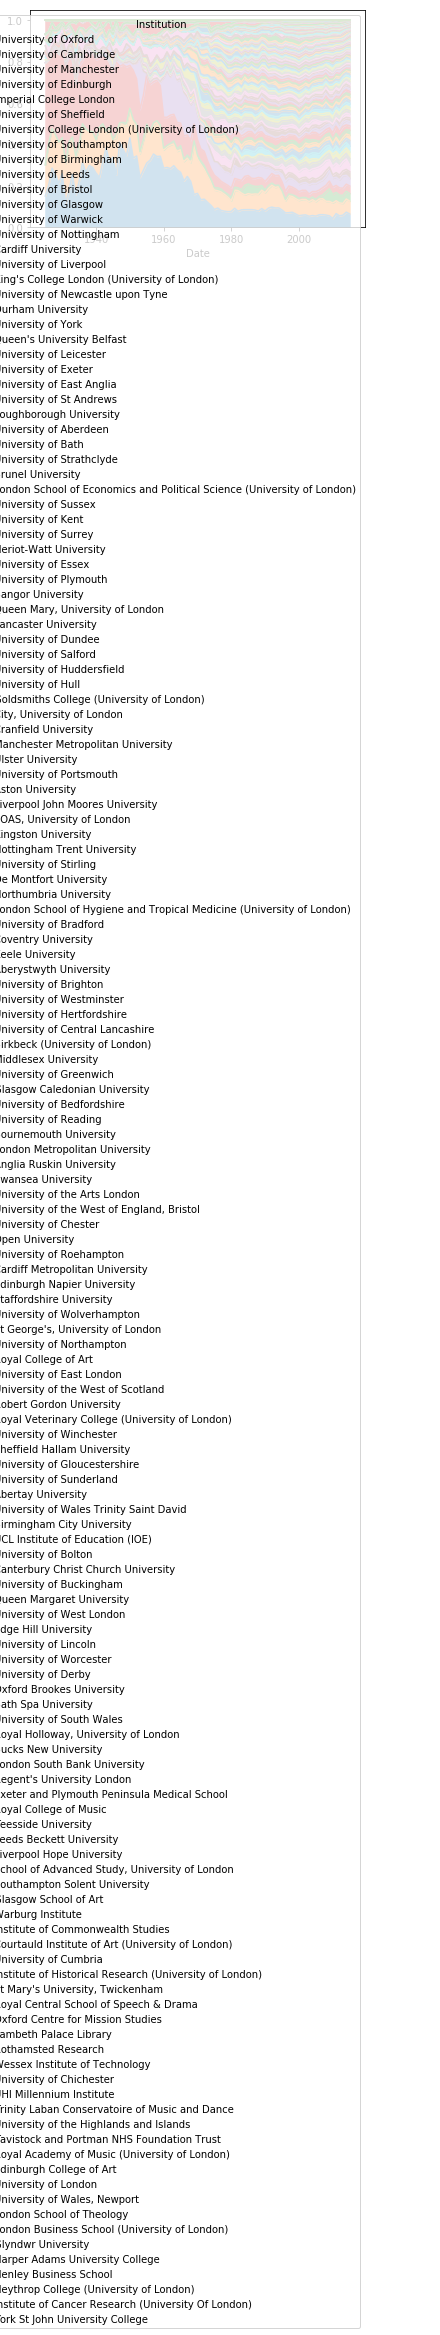

In [13]:
# TODO Fix legend
instratios_by_year.plot.area(legend=False)
instratios_by_year.plot.area(legend=True)

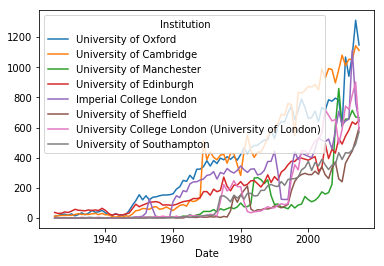

In [14]:
counts_by_yearandinst.iloc(1)[:8].plot()

In [369]:
def splitstr(s):
    """ For a string, remove most punctuation, lower case, and split into words. Return the words.
    """
    puncts = '!"&\'(),./:;<=>?[\\]`{|}-'
    return s.lower().translate(str.maketrans('', '', puncts)).split()

def filter_punctuationwords(l):
    """ Take a list of strings, filter out prepositions, articles, and other boring words. """
    verbotens = ["the", "a", "in", "on", "of", "at", "as", "so", "and", "or", "for", "to", "with", "an", "by", "it", "from", "its", "their", "them", "into", "onto"]
    return tuple(s for s in l if s not in verbotens)
# TODO Add combining plurals and singulars?

In [370]:
dfphd["Words"] = dfphd["Title"].apply(splitstr).apply(filter_punctuationwords)

In [371]:
def get_example_titles(word, n=1):
    titles_with_word = dfphd[dfphd["Words"].apply(lambda x: word in x)]["Title"]
    examples = tuple(titles_with_word.sample(n).values)
    return examples

In [372]:
wordcounts_by_year = dfphd.groupby("Date")["Words"].apply(
    lambda x: pd.Series(np.concatenate(x.tolist())).value_counts()
).unstack("Date").fillna(0.0)

In [373]:
total_wordcounts = wordcounts_by_year.sum(axis=1)
order = (-total_wordcounts).argsort()
total_wordcounts = total_wordcounts[order]
wordcounts_by_year = wordcounts_by_year.reindex(total_wordcounts.index)

In [374]:
wordrates_by_year = wordcounts_by_year.divide(counts_by_year, axis="columns")

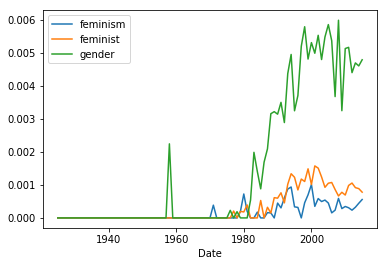

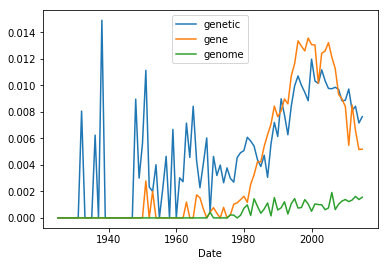

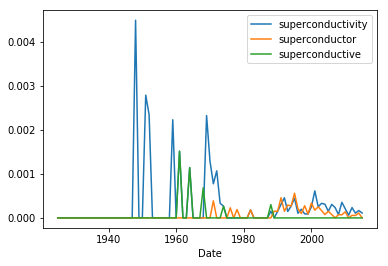

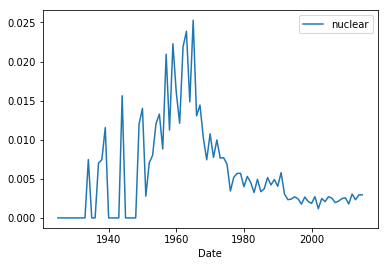

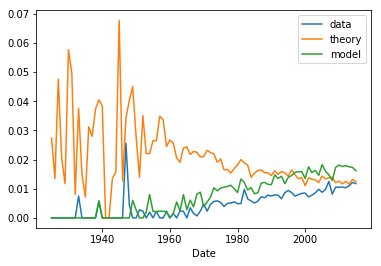

In [381]:
wordsets = (
    ["feminism", "feminist", "gender"],
    ["genetic", "gene", "genome"],
    ["superconductivity", "superconductor", "superconductive"],
    ["nuclear"],
    ["data", "theory", "model"]
)
for s in wordsets:
    wordrates_by_year.T[s].plot()

graphene
resilience
nanoparticle
epigenetic
biomarkers
nanoparticles
microfluidic
elearning
scaffolds
mitigation


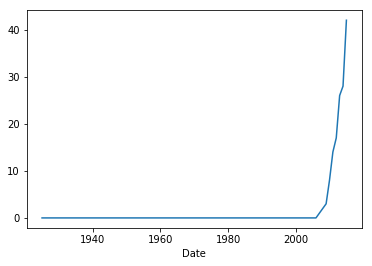

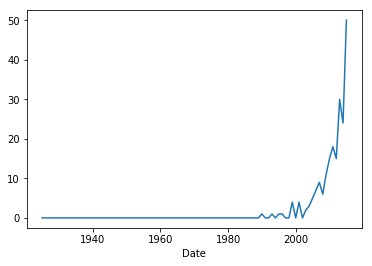

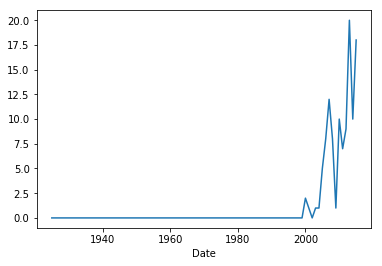

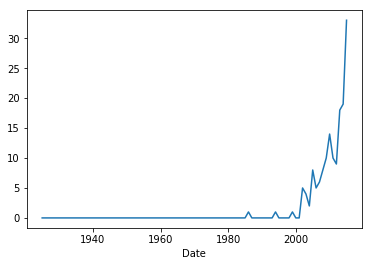

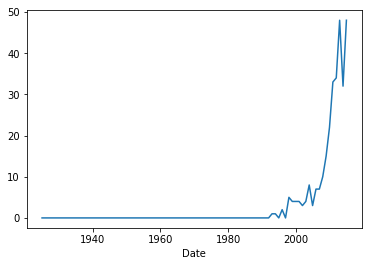

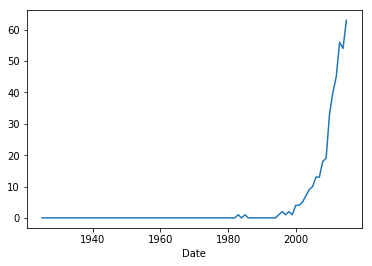

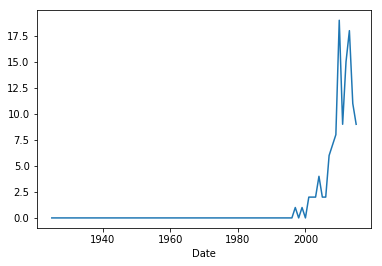

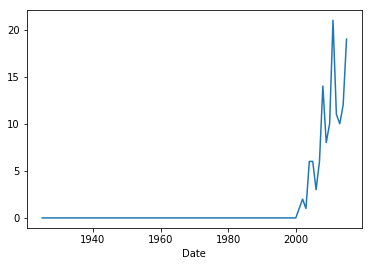

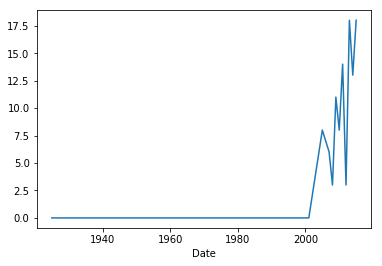

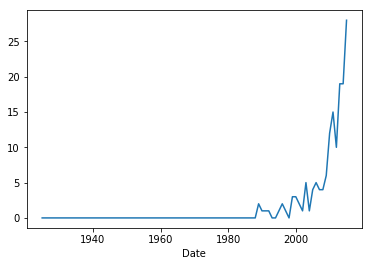

In [376]:
# TODO For each of the top words, get related words that it appears with, and example titles from the top years. 
M = wordcounts_by_year[total_wordcounts > 100].T
stds = (M.std()/M.mean()).sort_values(ascending=False)
topwords = stds.index[:10]
for w in topwords:
    print(w)
    fig = plt.figure()
    M[w].plot()

In [377]:
# TODO Make a graph of which words appear together, find groups of related terms in it
# to get labels for things like research fields.
# Then study how different institutions focus on different fields at different times.

In [378]:
# TODO Can I find correlations between words in titles at institutions, and their university rankings?
# Suggestion: https://www.leidenranking.com/ranking/2019/chart

In [379]:
print(total_wordcounts[10000], total_wordcounts.index[10000])

33.0 1986


In [380]:
samples = 100000
counter = 0
mainwords_number = 1000
mainwords = total_wordcounts.index[:mainwords_number]
cooccurence = pd.DataFrame(0.0, index=mainwords, columns=mainwords)
for words in dfphd["Words"]:
    words = tuple(filter(lambda w: w in mainwords, words))
    cooccurence.loc[words, words] += 1.0
    counter += 1
    if counter > samples:
        break

In [406]:
# TODO Should I rather make a bidirectional graph with different weights going two ways?
#      If I normalize by only row/column, then each value is the frequency of one word appearing given another.
#      The problem with this is that rows/columns can become dominated by very rare or very common words.
#diag_sqrt = np.sqrt(total_wordcounts[mainwords])
#cooccurence = cooccurence.divide(diag_sqrt, axis=0).divide(diag_sqrt, axis=1)
D = np.diag(cooccurence.values)
ones = np.ones(D.shape)
DD = np.outer(D, ones) + np.outer(ones, D)
cooccurence = 2*cooccurence.divide(DD)

In [407]:
import networkx as nx

In [408]:
adjmat = np.array(cooccurence.values)  # Makes a copy, to avoid modifying the original.
np.fill_diagonal(adjmat, 0.0)
g = nx.from_numpy_matrix(adjmat)

In [409]:
labels = {i: cooccurence.index[i] for i in range(len(cooccurence.index))}
g = nx.relabel_nodes(g, labels)

In [410]:
testword = "study"
d = dict(g.adjacency())[testword]
sorted([(v["weight"], k) for k, v in d.items()], reverse=True)[:100]

[(0.18810102504491177, 'case'),
 (0.12052995661859538, 'comparative'),
 (0.06016165319556704, 'development'),
 (0.0568868514273807, 'reference'),
 (0.054600606673407485, 'education'),
 (0.05238459019971625, 'between'),
 (0.05020624631703005, 'experimental'),
 (0.04652178661133559, 'social'),
 (0.04325062599590257, 'english'),
 (0.04005805515239477, 'using'),
 (0.037860444640105656, 'management'),
 (0.03653949489521763, 'use'),
 (0.03449449676614093, 'special'),
 (0.03319696084161309, 'change'),
 (0.032995183932779996, 'some'),
 (0.031742354031510656, 'england'),
 (0.03143893591293833, 'school'),
 (0.03107658157602664, 'role'),
 (0.03102223883386283, 'systems'),
 (0.03024747937671861, 'policy'),
 (0.030241286863270777, 'application'),
 (0.028554431885782272, 'industry'),
 (0.028342857142857142, 'british'),
 (0.02813705468572725, 'factors'),
 (0.02757132582114601, 'relationship'),
 (0.027417027417027416, 'critical'),
 (0.027188562053205204, 'learning'),
 (0.027095877721167207, 'process')

In [411]:
import community as louvain

In [412]:
dendrogram = louvain.generate_dendrogram(g)

In [415]:
partition = louvain.partition_at_level(dendrogram, 1)
communities = pd.DataFrame({"Community": tuple(partition.values())}, index=partition.keys()).groupby("Community").groups
communities = tuple(map(tuple, communities.values()))
print(len(communities))
print([len(c) for c in communities])
[print(c) for c in communities]

3
[417, 220, 363]
('study', 'development', 'case', 'social', 'reference', 'between', 'theory', 'management', 'new', 'education', 'evaluation', 'impact', 'policy', 'english', 'british', 'learning', 'health', 'towards', 'early', 'special', 'uk', 'change', 'england', 'process', 'practice', 'political', 'assessment', 'comparative', 'information', 'through', 'children', 'language', 'politics', 'critical', 'economic', 'work', 'history', 'community', 'relationship', 'life', 'state', 'culture', 'evolution', 'identity', 'international', 'industry', 'within', 'environmental', 'women', 'public', 'law', 'south', 'britain', 'century', 'quality', 'understanding', 'context', 'particular', 'implications', 'risk', 'strategies', 'care', 'construction', 'urban', 'school', 'developing', 'european', 'environment', 'knowledge', 'technology', 'local', 'contemporary', 'people', 'primary', 'relations', 'cultural', 'national', 'experience', 'planning', 'exploration', 'perspective', 'northern', 'art', 'framework

[None, None, None]

In [418]:
wordscores = pd.DataFrame({"word": total_wordcounts.index}).set_index("word")
for i, c in enumerate(communities):
    wordscores[i] = cooccurence.loc[:, c].sum(axis=1)
#wordscores.columns = ["Humanities", "Experimental", "Theory", "Bio"]
wordscores.columns = ["Humanities", "Bio", "Science"]
wordscores = wordscores.fillna(0.0)

In [434]:
for c in ["Humanities", "Bio", "Science"]:
    print(c)
    print(wordscores.sort_values(c, ascending=False)[:20])

Humanities
             Humanities       Bio   Science
word                                       
case           6.762936  0.482581  0.995820
education      6.663378  0.362045  0.566990
reference      6.613690  0.996046  1.249045
policy         6.048497  0.330542  0.683511
social         5.891548  0.693352  0.752292
school         5.799141  0.455613  0.514544
special        5.729130  0.774592  0.949437
united         5.400067  0.312216  0.512542
health         5.362756  0.856669  0.653726
study          5.352746  1.159014  2.063745
management     5.251017  0.658373  1.486773
teachers       5.214618  0.303207  0.361434
english        5.213161  0.338474  0.642039
practice       5.188569  0.455086  0.645284
public         5.155542  0.252489  0.563513
political      5.131586  0.244015  0.408262
england        5.112399  0.454244  0.596510
change         5.095728  0.507394  0.813917
schools        5.092233  0.212547  0.415443
comparative    5.063290  0.756281  0.781339
Bio
             Huma

In [419]:
for c in wordscores.columns:
    print("Computing title scores for {}.".format(c))
    # The python sum function is significantly faster here than a sub-DataFrame.sum().
    dfphd[c] = dfphd["Words"].apply(lambda ws: sum(wordscores.loc[w, c] for w in ws)/(len(ws) if len(ws) > 0 else 1))

Computing title scores for Humanities.
Computing title scores for Bio.
Computing title scores for Science.


In [447]:
for c in ["Humanities", "Bio", "Science"]:
    print(c)
    print(dfphd[["Title", c]].sort_values(c, ascending=False).set_index("Title")[:20])

Humanities
                                                    Humanities
Title                                                         
On reference                                          6.613690
The impact of education on political development      5.287715
Learning from experience : the case study of a ...    5.175110
Understanding in education                            5.147205
Professional education in social work; learning...    5.074212
The learning and teaching of English as a forei...    5.071817
Learning in social work practice                      5.066324
Policy formation in the European Union : the ca...    5.025873
The Chinese community in Britain : with special...    5.006747
Mental health policy implementation : a case study    4.976964
Policy, curriculum and the teaching of English ...    4.970202
Experiences of education                              4.969325
A case study of cultural change from an educati...    4.960124
Education policy in East Germany            

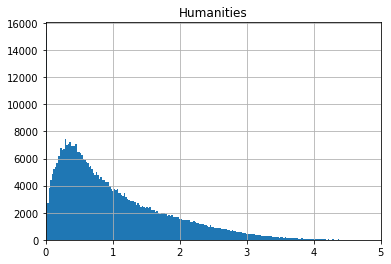

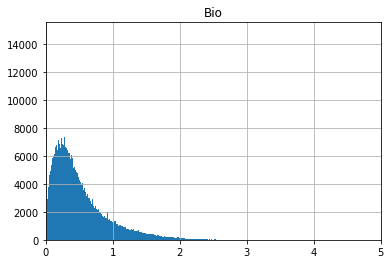

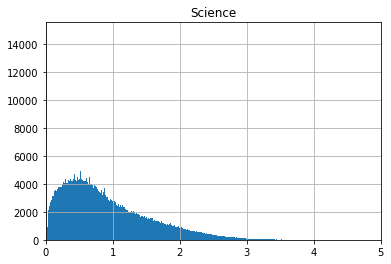

<Figure size 432x288 with 0 Axes>

In [448]:
for c in wordscores.columns:
    dfphd[c].hist(bins=300)
    plt.title(c)
    plt.xlim(0.0, 5.0)
    plt.figure()

In [449]:
dfphd[wordscores.columns].corr()

,Humanities,Bio,Science
Humanities,1.000000,-0.076961,-0.055008
Bio,-0.076961,1.000000,0.203172
Science,-0.055008,0.203172,1.000000


(0.0, 2.0)

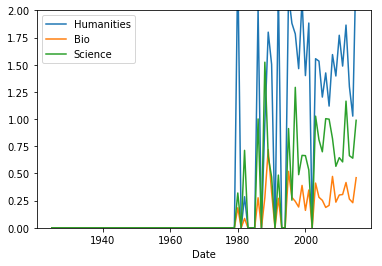

<Figure size 432x288 with 0 Axes>

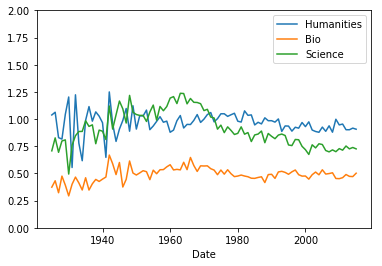

<Figure size 432x288 with 0 Axes>

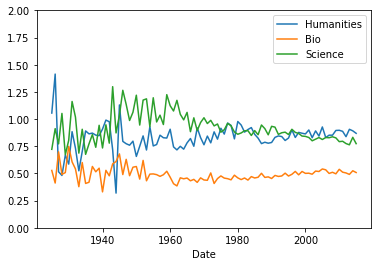

<Figure size 432x288 with 0 Axes>

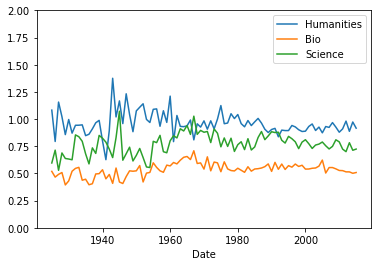

<Figure size 432x288 with 0 Axes>

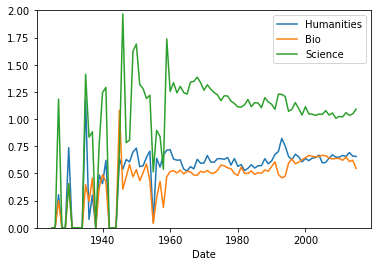

In [451]:
meanscores_by_yearandinst = dfphd.groupby(["Institution", "Date"]).mean().unstack("Institution").fillna(0.0).reorder_levels([1, 0], axis=1)
meanscores_by_yearandinst["Glasgow School of Art"].plot()
plt.ylim(0.0, 2.0)
plt.figure()
meanscores_by_yearandinst["University of Oxford"].plot()
plt.ylim(0.0, 2.0)
plt.figure()
meanscores_by_yearandinst["University of Cambridge"].plot()
plt.ylim(0.0, 2.0)
plt.figure()
meanscores_by_yearandinst["University of Edinburgh"].plot()
plt.ylim(0.0, 2.0)
plt.figure()
meanscores_by_yearandinst["Imperial College London"].plot()
plt.ylim(0.0, 2.0)

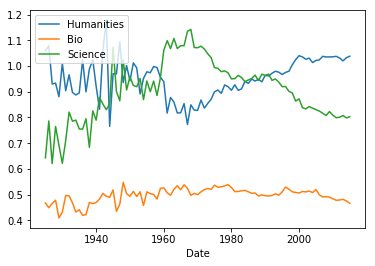

In [426]:
meanscores_by_year = dfphd.groupby(["Date"]).mean().fillna(0.0)
meanscores_by_year.plot()

In [157]:
# TODO Fun experiment: Find titles where the words are very far apart in graph-distance, i.e. exceptional titles.